In [208]:
import wandb
import subprocess
import os
import torch
import matplotlib.pyplot as plt
import mixed_BVP as bvp
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid") # better looking plots
import deepxde as dde

Using backend: pytorch



# Hyperparameter optimization with Weights and Biases

In [20]:
# Initialize the wandb sweep with the possible values for the hyperparameters
sweep_dict = {
    'net_type': {'values': ['Unet','USnet']},
    'n_layers': { 'max': 10,'min': 2},
    'size_layers': {'values': [50,75,100]},
    'activation': {'values': ['tanh','sigmoid']},
    'loss_type': {'values':  ['pde']},
    'num_samples': {'values': [25,50,75,100]},
    'bc_type': {'value': 'hard'},
    'train_distribution': {'value': 'Hammersley'},
    'optimizers': {'value': ["adam"]},
    'learning_rates': {'value': [1e-3]},
    'iterations': {'value': [300]}
}
#Bayesian updating hyper-optimization to minimize accuracy metric
sweep_config = {
    'method': 'bayes',
    'parameters': sweep_dict,
    'metric': {
        'name': 'accuracy_metric',
        'goal': 'minimize'   
    },
    'name': 'sweep-1',
    'program': 'mixed_BVP.py'
    }

project_name = 'HPO-PINN-CM'
sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: 4sh96xkg
Sweep URL: https://wandb.ai/damien-bonnet/HPO-PINN-CM/sweeps/4sh96xkg


In [229]:
wandb_profile = "damien-bonnet"
project_name = 'HPO-PINN-CM'

sweep_id = "4sh96xkg"
count = 1

#command line to run agent from the terminal
cmd_line = f"wandb agent {wandb_profile}/{project_name}/{sweep_id} --count {count}"
print(f"Command line:\n{cmd_line}")

Command line:
wandb agent damien-bonnet/HPO-PINN-CM/4sh96xkg --count 1


In [50]:
#run the agent in the notebook

wandb_train = bvp.wandb_train
wandb.agent(sweep_id, bvp.wandb_train, count=count)

Results of the HPO are availbale at : https://api.wandb.ai/links/damien-bonnet/2ok0l39j

# Assess stochasticity of the optimization
Even though the HPO study shows an influence of some parameters on the final accuracy, it’s important to assess if this correlation is significant compared to the noise of the results (due to the stochasticity of the optimization). To quantify this noise we compute several runs with the same configuration.
The following hyperparameters configuration is chosen as it performed well and has a limited number of NN weight and biases (reducing the computation cost)

In [ ]:
# choosing a configuration
#net parameters
net_type= 'USnet'
n_layers= 3
size_layers= 100
activation= 'sigmoid'

#loss parameters
loss_type= ['pde','energy'][0]#the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_samples= 100
train_distribution= 'Hammersley'

#boundary conditions
bc_type= 'hard'

#optimizer
optimizers= ["adam","L-BFGS"]
learning_rates= [1e-3,None]
iterations= [3000,None]

configuration = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_samples':num_samples,'train_distribution':train_distribution,
        'bc_type':bc_type,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter=10000)
save_model = True
nb_runs = 25
geom = dde.geometry.Rectangle([0, 0], [1, 1])

for run in range(nb_runs):
    with wandb.init(project="HPO-PINN-CM", config=configuration):
        config = wandb.config
        config["num_domain"] = config["num_samples"]**2
        config["num_boundary"] = config["num_samples"]
        model = bvp.model_setup(geom,config)
        model_save_path = os.path.join(wandb.run.dir, "model") if save_model else None
        losshistory, train_state = bvp.train_model(model,config,model_save_path=model_save_path)
        bvp.log_run(config,losshistory)

# Load saved model and plot solution

In [51]:
import yaml
import glob
  
def load_config(path):  
    with open(path, 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
        config.pop('wandb_version')
        config.pop('_wandb')
        for key, val in config.items():
            config[key] = val["value"]
    return config

def path_from_id(run_id):
    config_path = os.path.join('wandb',f"*-{run_id}","files")
    return glob.glob(config_path)[0]

def load_model(run_id,device=None):
    config_path = os.path.join(path_from_id(run_id),"config.yaml")
    model_path = os.path.join(path_from_id(run_id),"model-*.pt")
    model_path = glob.glob(model_path)[-1]
    config = load_config(config_path)
    config["num_domain"] = config["num_samples"]**2
    config["num_boundary"] = config["num_samples"]    
    model = bvp.model_setup(bvp.geom,config)

    model.compile('adam', lr=0.001)
    model.restore(model_path,device=device)    
    return model, config

Compiling model...
'compile' took 0.000318 s



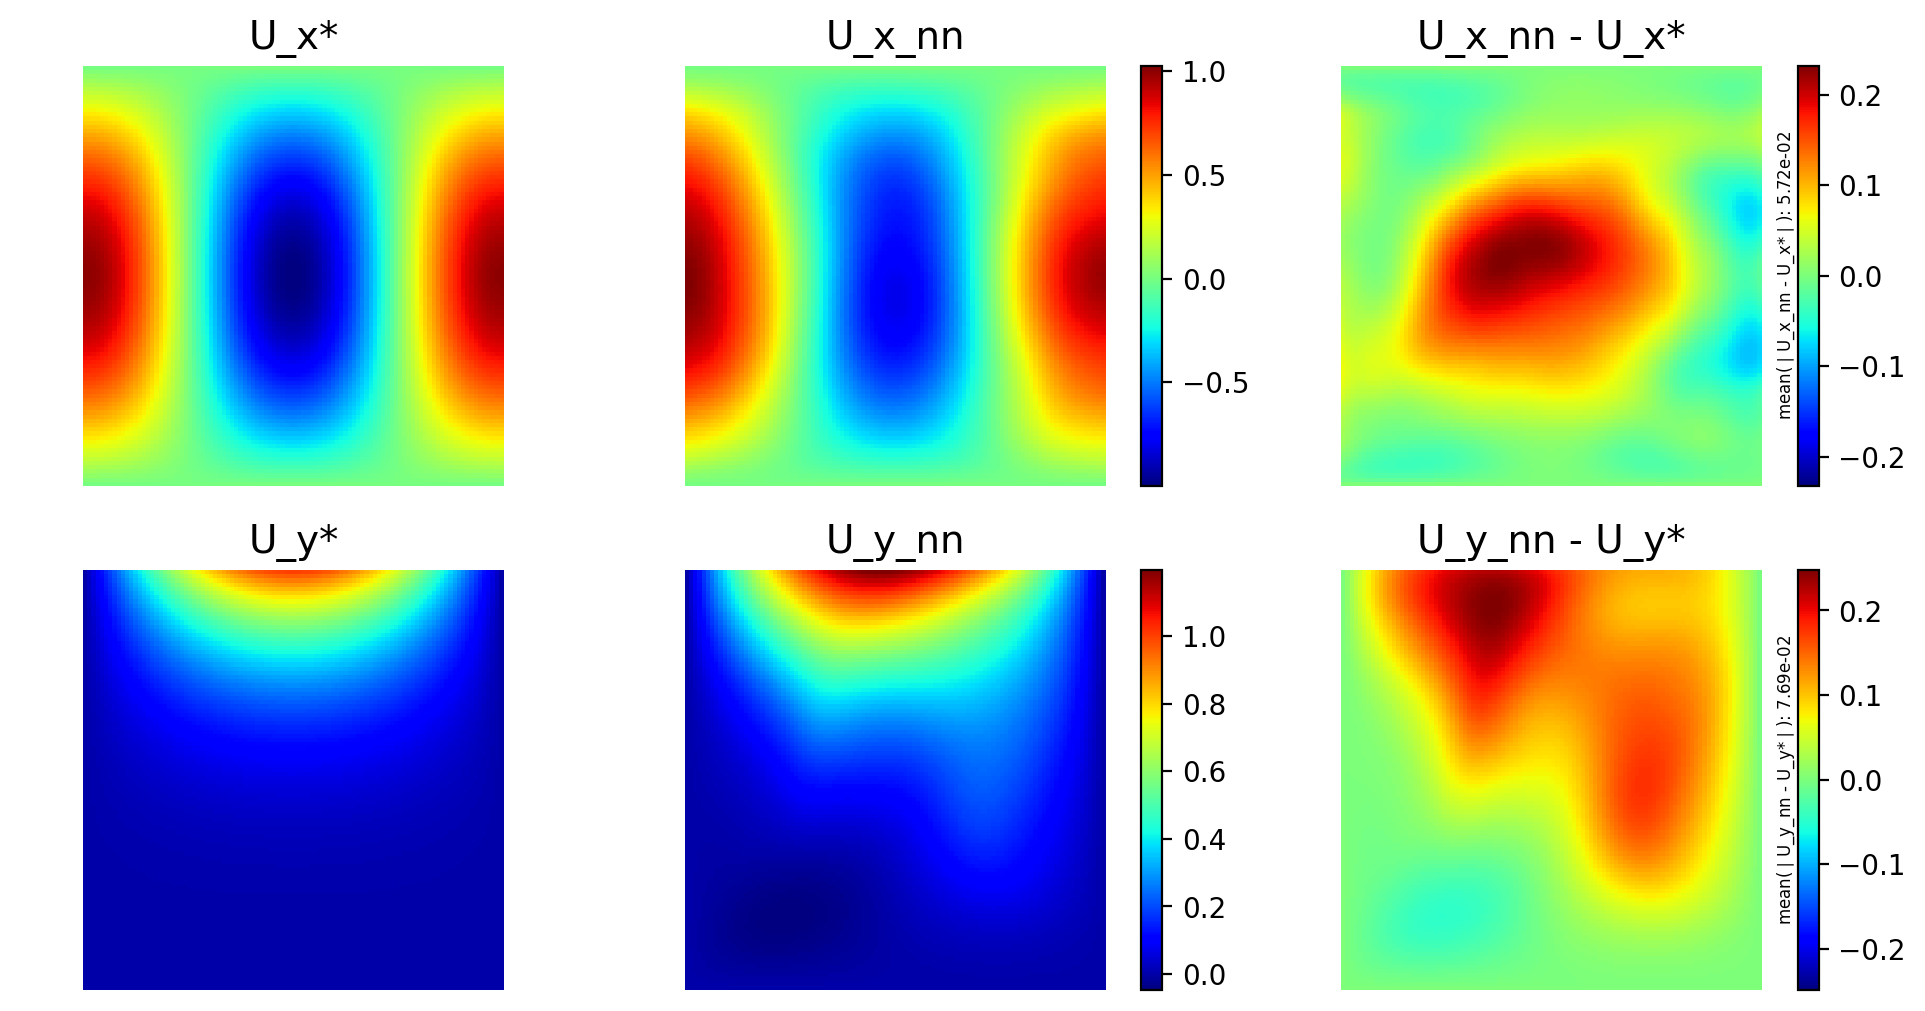

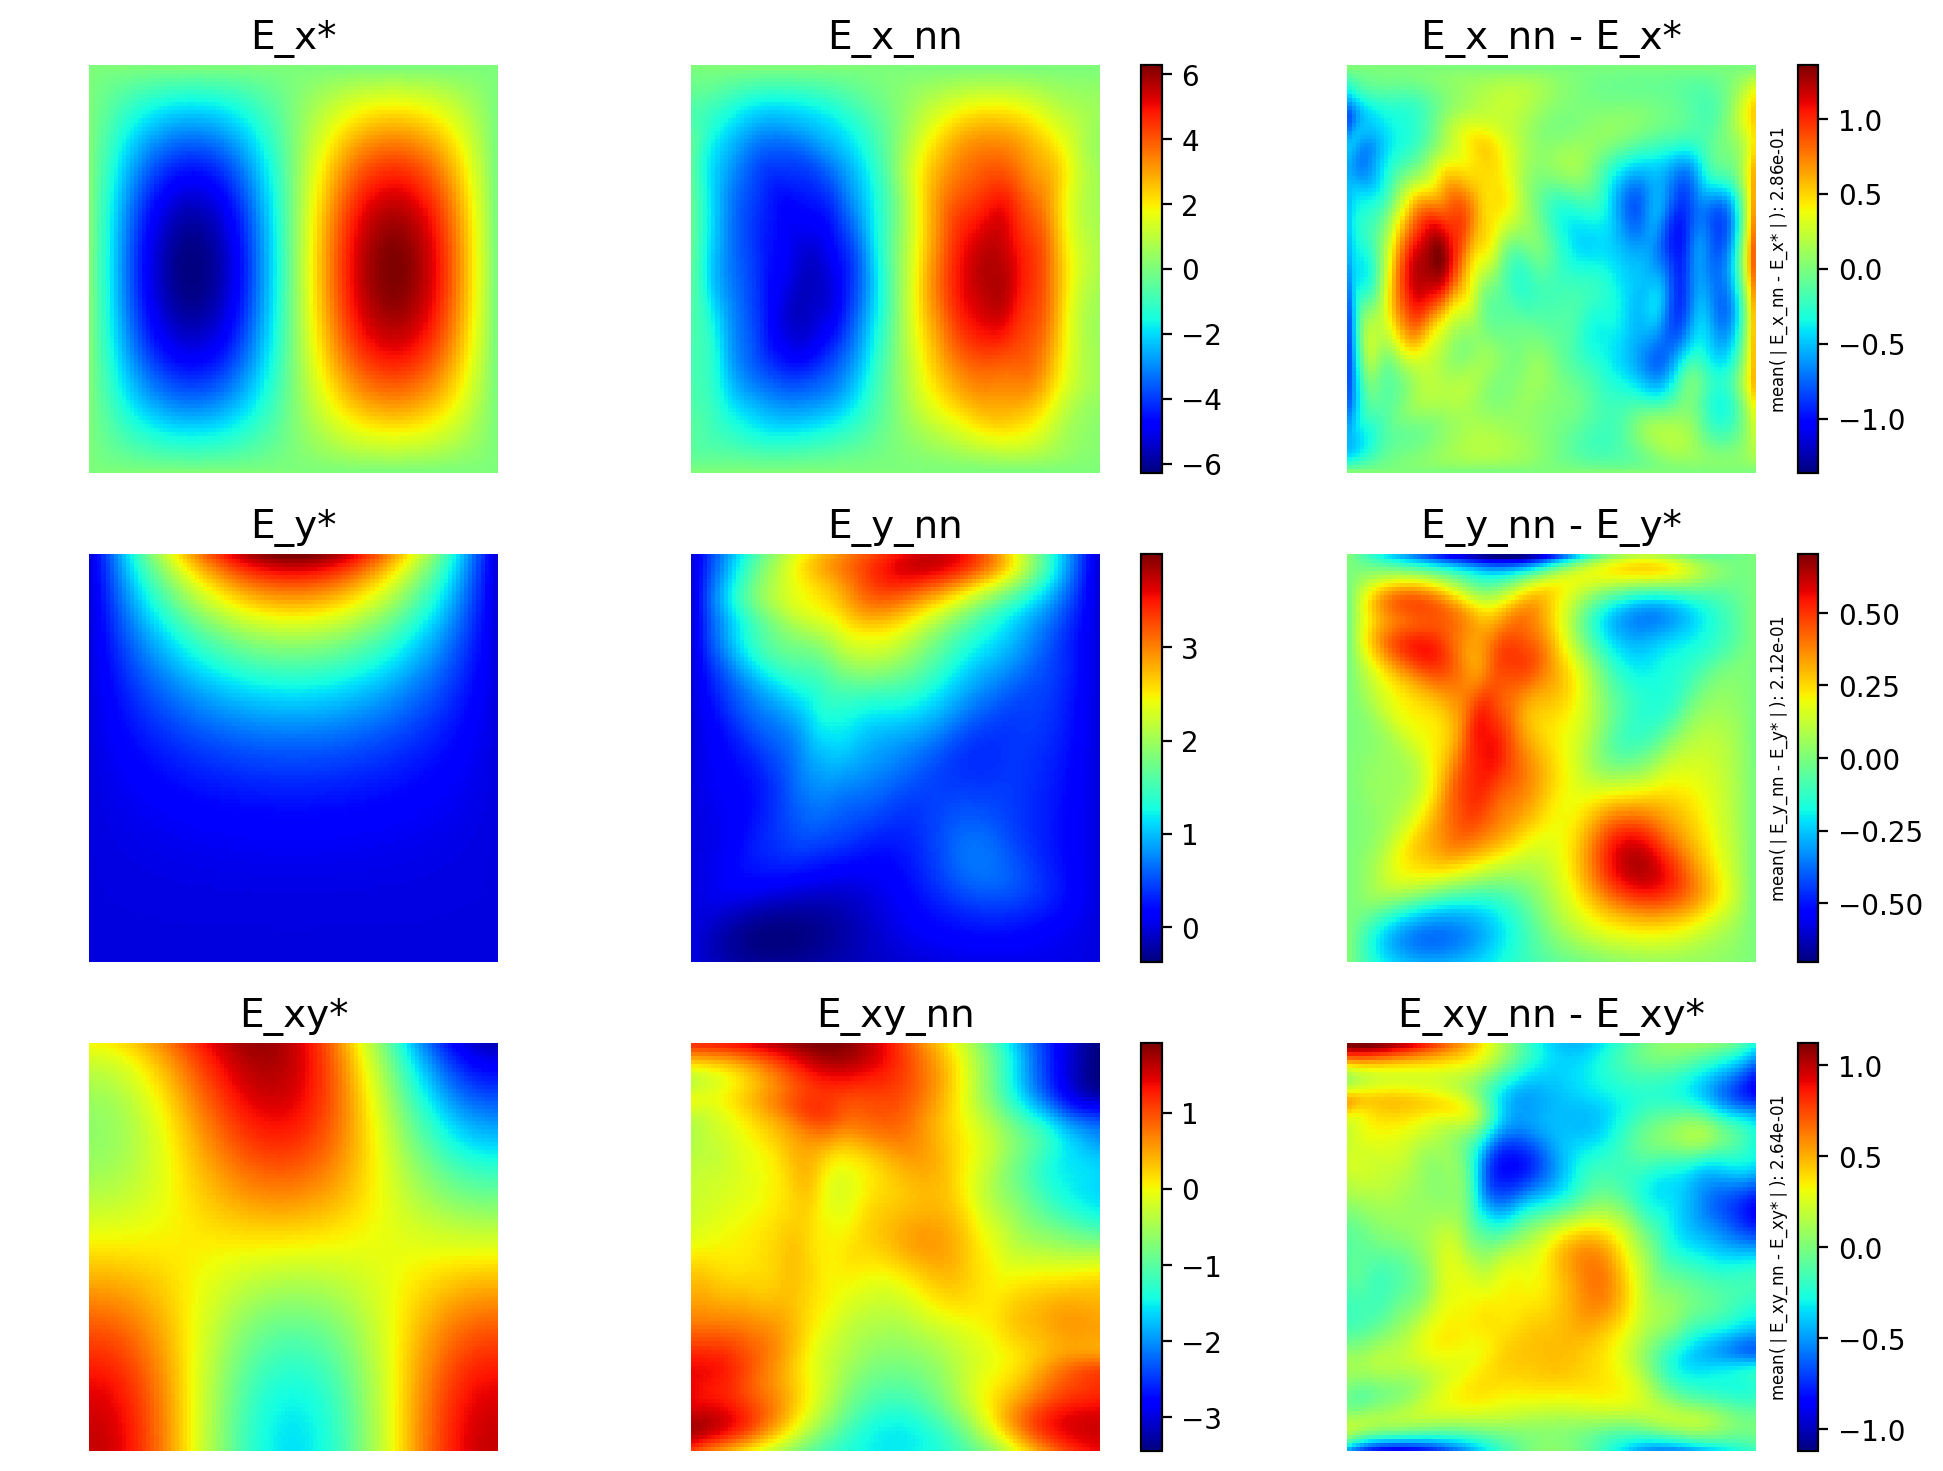

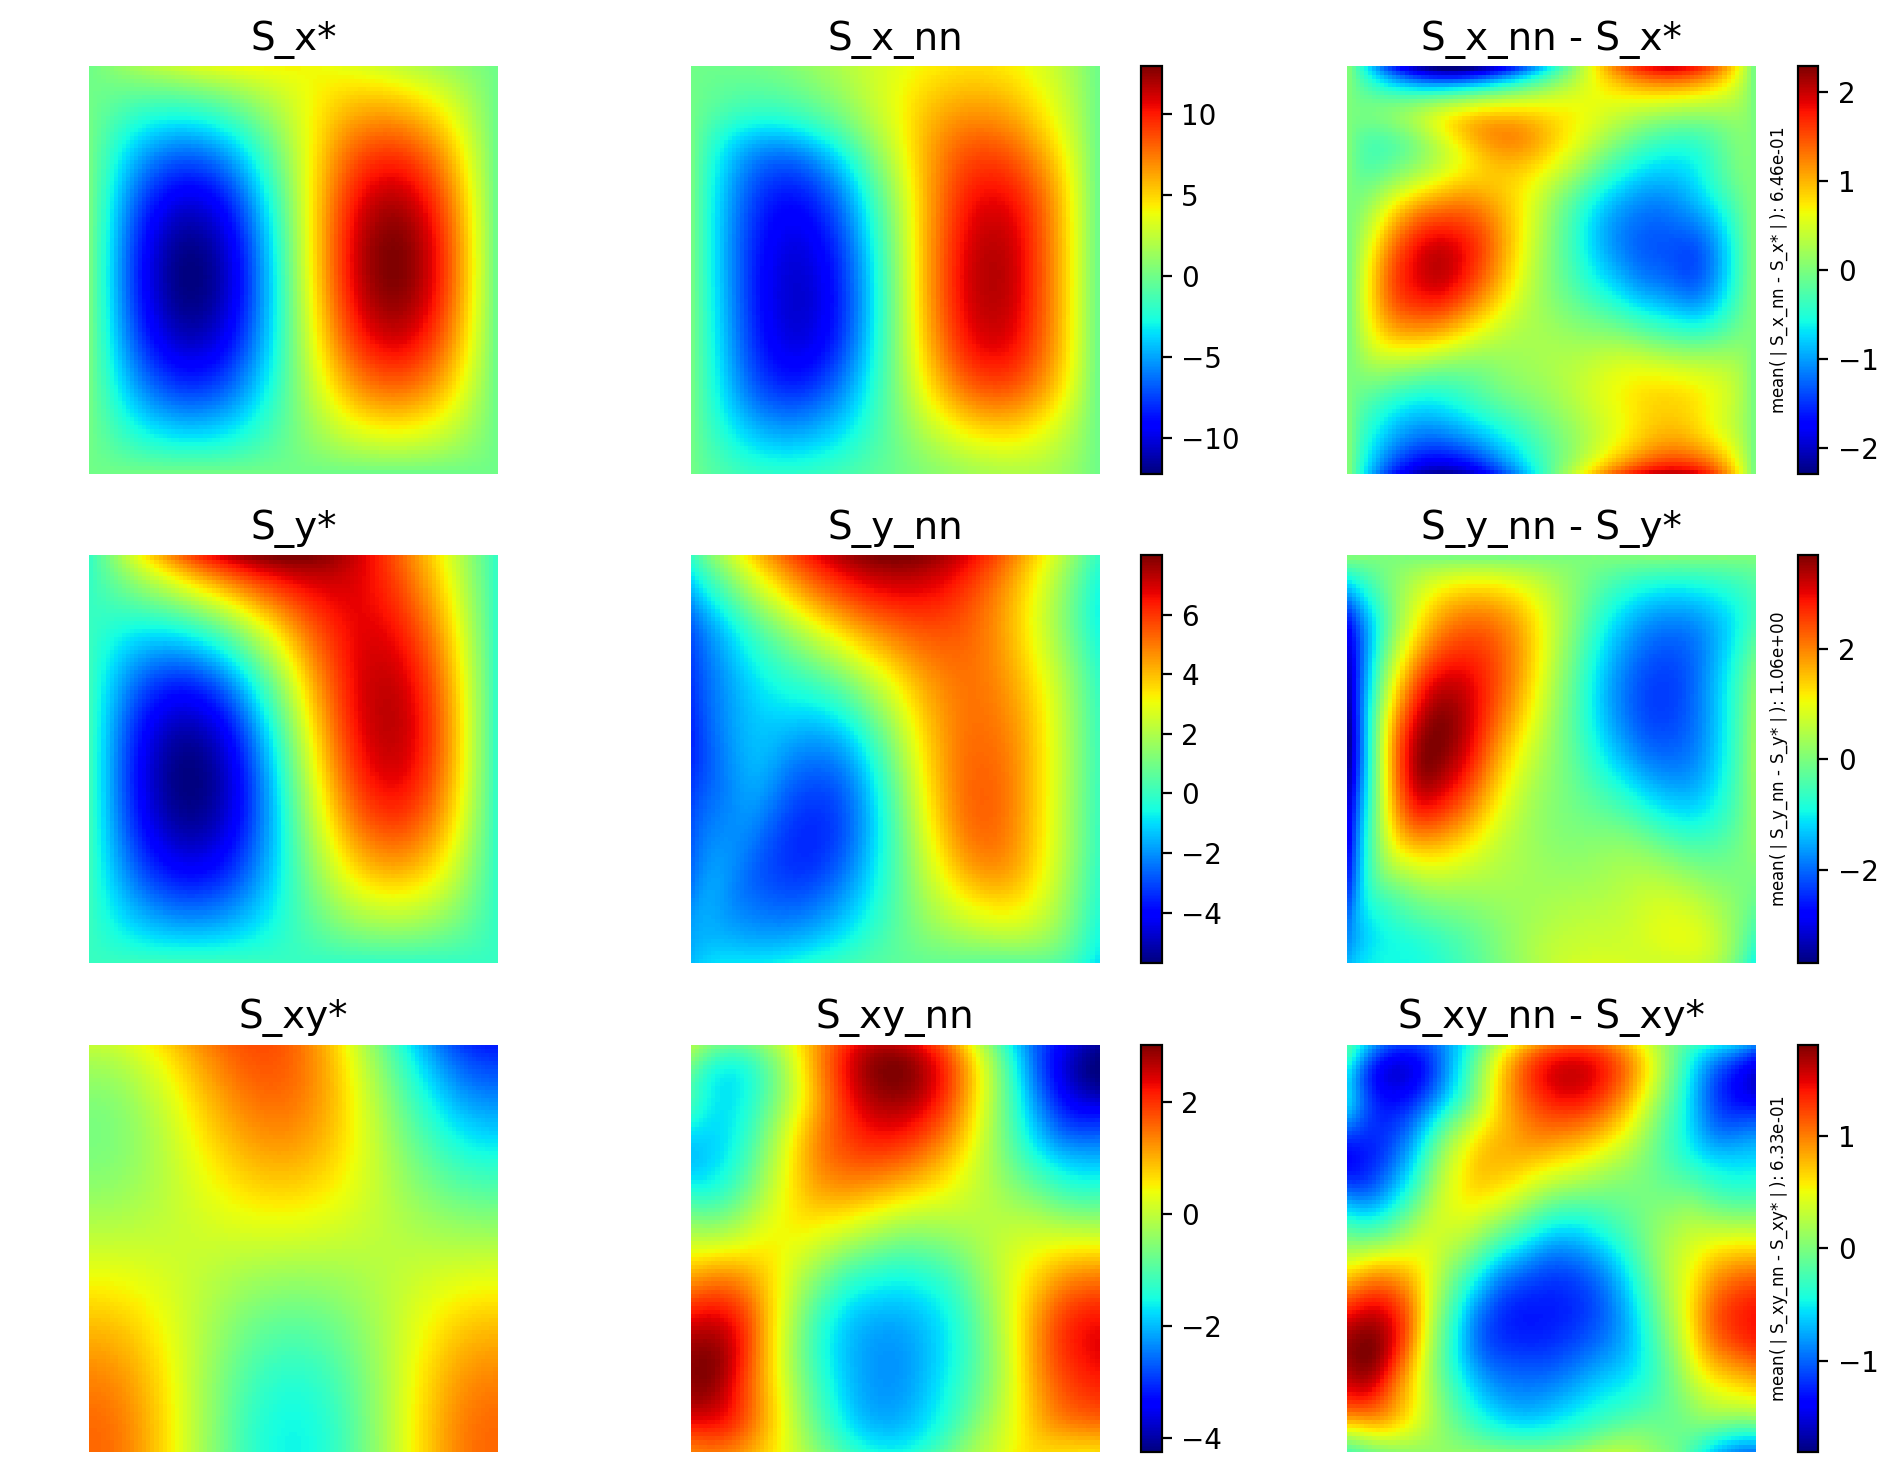

In [53]:
run_id = "1l1q5s6s"

model, config = load_model(run_id)

# Plotting the final solution

U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: S_nn(E_nn(x,ouput)) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

U_field = bvp.plot_field(bvp.domain,model,output_func=U_output,V_exact=lambda x: (bvp.U_exact(x)[:,0], bvp.U_exact(x)[:,1]),plot_diff=True,fields_name="U")
E_field = bvp.plot_field(bvp.domain,model,output_func=bvp.E_nn,V_exact=bvp.E_exact,plot_diff=True)
S_field = bvp.plot_field(bvp.domain,model,output_func=S_output,V_exact=bvp.S_exact,plot_diff=True)

# General results
All the results are available on the Weights and Biases report : https://api.wandb.ai/links/damien-bonnet/2ok0l39j

In [219]:
plot_type = ['boxplot', 'violinplot'][1]

def plot_distribution(ax,df, parameter,plot_type="violinplot",strip=True,label_info=True,save_fig=False):
    if plot_type == 'boxplot':
        sns.boxplot(x=parameter, y='accuracy_metric', data=df, ax=ax)#, color="0.8")

    elif plot_type == 'violinplot':
        sns.violinplot(x=parameter, y='accuracy_metric', data=df, ax=ax,inner="quartile")
  
    for patch in ax.collections:
        patch.set_alpha(0.7)  
        
    if strip:    
        sns.stripplot(x=parameter, y='accuracy_metric', data=df,ax=ax, jitter=0.03, zorder=1, size=5, alpha=0.6, color="black")
    if label_info:
        # Calculate mean and number of points for each category
        mean_values = df.groupby(parameter)['accuracy_metric'].mean()
        std_values = df.groupby(parameter)['accuracy_metric'].std()
        count_values = df[parameter].value_counts()

        # Add labels for each category
        column_values = sorted(df[parameter].unique(),key=str.casefold if isinstance(df[parameter].iloc[0],str) else lambda x: x)
        for i, value in enumerate(column_values):
            mean = mean_values[value]
            std = std_values[value]
            count = count_values[value]
            label = f"Mean: {mean:.2e}\nStd: {std:.2e}\nCount: {count}"
            ax.annotate(label, xy=(i, mean), xytext=(i, 0.9*ax.get_ylim()[1]), ha='center', va='bottom',
                bbox=dict(boxstyle='square,pad=0.5', fc='1', ec='0.5'))
            
    if save_fig:
        plt.savefig(f"results/figures/{parameter}_influence.png",dpi=300)

Standard deviation ratio = 2.51


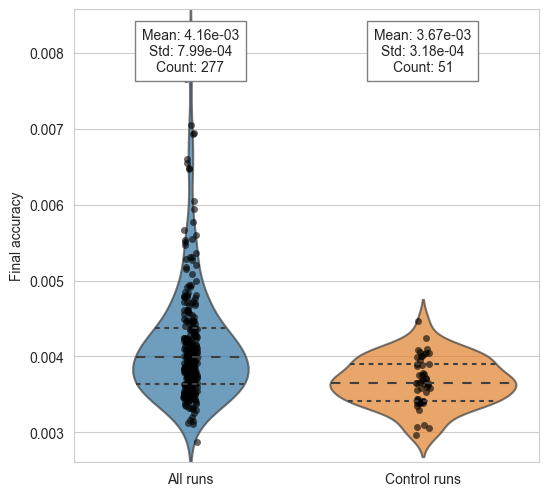

In [228]:
# Read the CSV file into a pandas DataFrame
df_all = pd.read_csv('results/HPO_results.csv')

df_all['Sweep'].fillna("Control runs", inplace=True)
df_all['Sweep'].replace("hsnp1x74", "All runs", inplace=True)

df_sweep = df_all[df_all['Sweep'] != "Control runs"]
df_control = df_all[df_all['Sweep'] == "Control runs"]

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plot_distribution(ax,df_all, parameter='Sweep',plot_type=plot_type)

# Set plot titles and axes labels
ax.set_ylabel('Final accuracy')
ax.set_xlabel('')

# Calculate the ratio of the standard deviation
std_ratio = df_sweep['accuracy_metric'].std() / df_control['accuracy_metric'].std()
print(f"Standard deviation ratio = {std_ratio:.2f}")

#Save figure
fig.savefig(f"results/figures/Variance_significance.png",dpi=300)

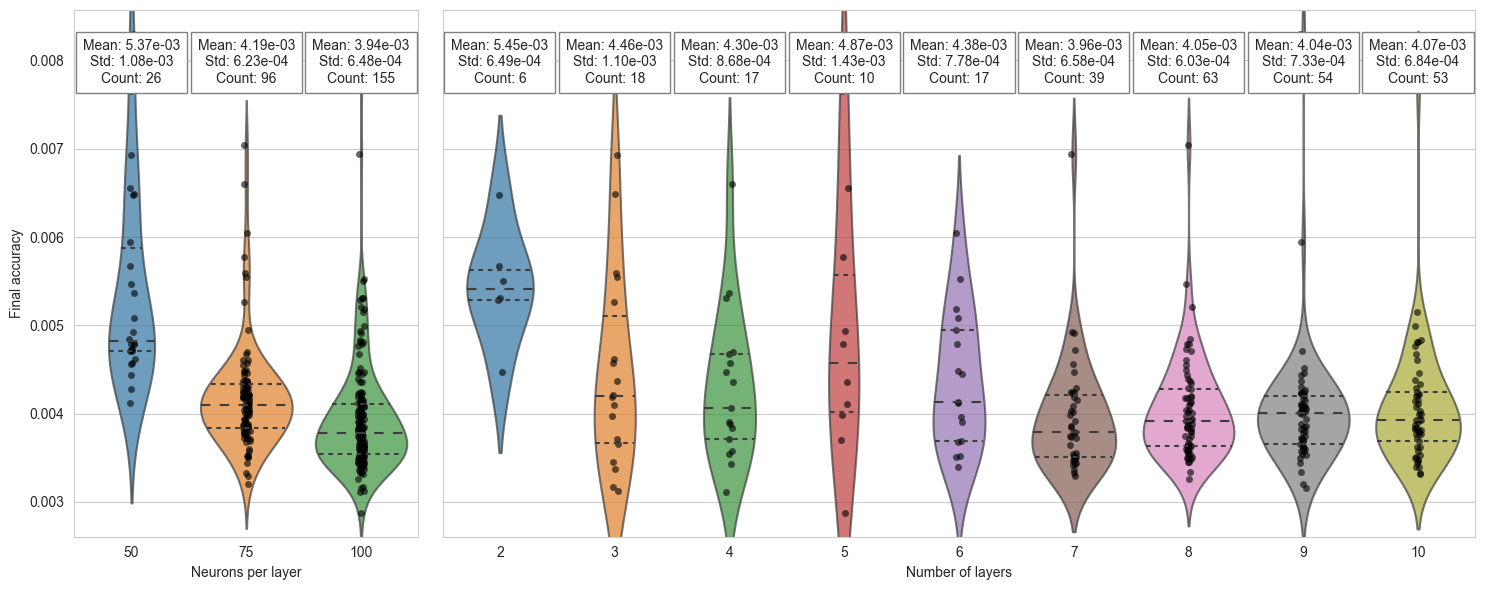

In [221]:
from matplotlib.gridspec import GridSpec
df = df_sweep
plot_type = ['boxplot', 'violinplot'][1]
strip = True
# Create a 3x3 grid with different cell sizes
fig = plt.figure(figsize=(15, 6), dpi=100)
grid = GridSpec(1, 2, width_ratios=[1,3], height_ratios=[1], figure=fig)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
plot_distribution(ax1,df, parameter='size_layers',plot_type=plot_type,strip=strip)
plot_distribution(ax2,df, parameter='n_layers',plot_type=plot_type,strip=strip)

ax1.set_ylabel('Final accuracy')
ax1.set_xlabel('Neurons per layer')
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.set_xlabel('Number of layers')

plt.tight_layout()
plt.show()

#Save figure
fig.savefig(f"results/figures/Network_architecture_influence.png",dpi=300)

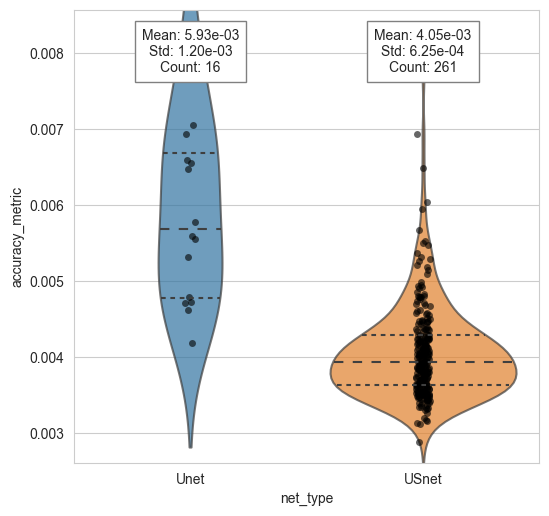

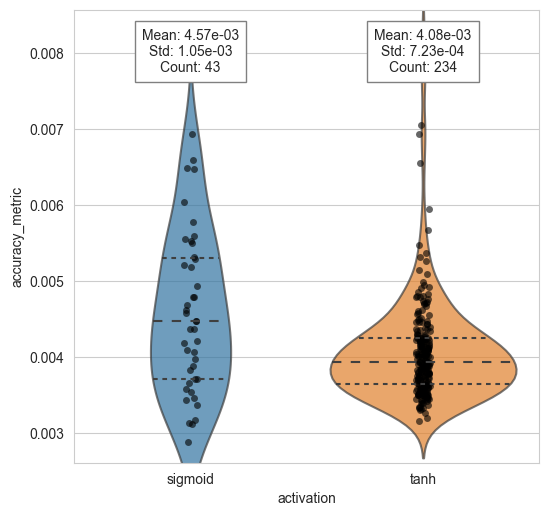

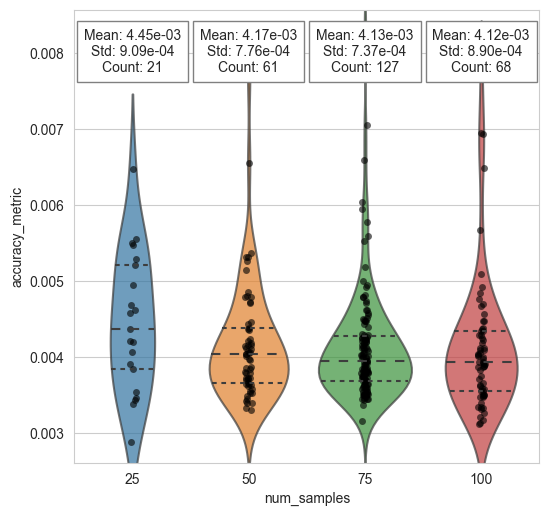

In [222]:
plot_type = ['boxplot', 'violinplot'][1]
fig,ax = plt.subplots(figsize=(6, 6), dpi=100)
plot_distribution(ax,df, parameter='net_type',plot_type=plot_type,strip=strip,save_fig=True)
fig,ax = plt.subplots(figsize=(6, 6), dpi=100)
plot_distribution(ax,df, parameter='activation',plot_type=plot_type,strip=strip,save_fig=True)
fig,ax = plt.subplots(figsize=(6, 6), dpi=100)
plot_distribution(ax,df, parameter='num_samples',plot_type=plot_type,strip=strip,save_fig=True)
